In [1]:
# should already be activated, but just a reminder where ya are :)  
# !conda activate wool_sucking_nn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

%matplotlib inline

# Table of Contents:
* [1. Import Training and Testing Data](#1data)  
    * [1.1 Import `master_scores` and `add_to_master`](#1.1master)  
* [2. Tensorflow.Keras Pre-Processing](#2tfprep)  
* [3. Modeling with Multilayer Perceptron (MLP)](#3model)  
    * [3.1 Plain Jane MLP](#3.1plainjane)  
    * [3.2 Adagrad optimizer](#3.2adagrad)  
    * [3.3 Scale Standardization](#3.3scaling)  
    * [3.4 Playing with # of Nodes](#3.4playing)  
    * [3.5 Resampling to deal with class imbalance](#3.5resample)  
    * [3.6 MLP without `Grooming` feature](#3.6dropgroom)  
* [4. Model Evaluation](#4evaluation)  
    * [4.1 Training and Prediction Time Compared to Logistic Regression](#4.1)  
    * [4.2 Compare Classification MLP Performance Metrics to Log Reg](#4.2)  
        * [4.2.1 Logistic Regression without `Grooming` feature](#4.2.1)  
    * [4.3 MLP classification performance on old data (from cat-pstone 1)](#4.3)

# <a id='1data'></a> 1. Import Training and Testing Data 

In [2]:
# import data
excel_file = pd.read_excel('..\Data\cleaned_and_split_data.xlsx', sheet_name=None)

# Unpack the dataframes into separate variables
X_train = excel_file['X_train']
X_test = excel_file['X_test']
y_train = excel_file['y_train']
y_test = excel_file['y_test']

In [3]:
print(X_train.shape)
X_train.head()

(3965, 7)


,Neuter_status,Breed_group,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming
0,1,SIB,1,2,4,4,3
1,1,HCS,1,2,4,4,2
2,0,ORI,1,1,1,1,1
3,1,MCO,1,1,2,2,3
4,1,HCS,1,1,2,1,2


In [4]:
print(X_test.shape)
X_test.head()

(1700, 7)


,Neuter_status,Breed_group,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming
0,1,SIB,1,3,3,1,1
1,1,MCO,1,1,2,1,1
2,1,RUS,1,1,4,4,1
3,0,EUR,2,2,2,2,1
4,1,NFO,1,2,3,2,1


In [5]:
print(y_train.shape)
y_train.head()

(3965, 1)


,Wool_sucking_binary
0,0
1,0
2,0
3,0
4,0


In [6]:
print(y_test.shape)
y_test.head()

(1700, 1)


,Wool_sucking_binary
0,1
1,1
2,1
3,0
4,1


## <a id='1.1master'></a>1.1 Create `master_scores` and `add_to_master`

In [7]:
# dataframe for scores amongst models
master_scores = pd.DataFrame(columns=['Model','Recall', 'F1', 'Precision', 'Accuracy'])

In [8]:
# add_to_master(model_description, y_true, y_predicted, binary=True)
def add_to_master(model_description, y_test, y_pred, binary=True):
    '''
    Adds a new row to the running score DataFrame `master_scores` 
    and functions for adding both binary and multiclass scores. 
    '''
    global master_scores
    if binary == True:
        # Evalution Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,3), 
            'F1': round(f1, 3), 
            'Precision': round(precision, 3), 
            'Accuracy': round(accuracy, 3)}
        
        master_scores = master_scores.append(new_row, ignore_index=True)   
    
    else:
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro') # I chose macro since we have less of the sucklers 
        recall = recall_score(y_test, y_pred, average='macro')       # and I want their accuracy to be meaningful
        f1 = f1_score(y_test, y_pred, average='macro')


        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,3), 
            'F1': round(f1, 3), 
            'Precision': round(precision, 3), 
            'Accuracy': round(accuracy, 3)}
        master_scores = master_scores.append(new_row, ignore_index=True)
    return master_scores

# <a id='2tfprep'></a> 2. Prep for tensorflow.keras

In [9]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
# for reproducibility 
tf.random.set_seed(42)
np.random.seed(42)

In [10]:
# one-hot breed 
X_train_encoded = pd.get_dummies(X_train, columns=['Breed_group'])
X_test_encoded = pd.get_dummies(X_test, columns=['Breed_group'])

In [11]:
X_train_encoded.shape

(3965, 25)

# <a id='3model'></a> 3. MLP Modeling

## <a id='3.1plainjane'></a> 3.1 Plain Jane

In [12]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(len(X_train_encoded.columns),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
# for some reason this isn't built in and needs to be formally declared 
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

tf.keras.utils.get_custom_objects()['recall'] = recall

In [14]:
model.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['accuracy', 'recall'])

In [15]:
model.fit(X_train_encoded, y_train, epochs=10, batch_size=32)

Epoch 1/10
124/124 [==============================] - 1s 916us/step - loss: 0.6274 - accuracy: 0.6810 - recall: 0.0167
Epoch 2/10
124/124 [==============================] - 0s 924us/step - loss: 0.6019 - accuracy: 0.6830 - recall: 0.1234
Epoch 3/10
124/124 [==============================] - 0s 892us/step - loss: 0.5937 - accuracy: 0.6898 - recall: 0.1853
Epoch 4/10
124/124 [==============================] - 0s 933us/step - loss: 0.5893 - accuracy: 0.6941 - recall: 0.1681
Epoch 5/10
124/124 [==============================] - 0s 916us/step - loss: 0.5855 - accuracy: 0.6936 - recall: 0.1782
Epoch 6/10
124/124 [==============================] - 0s 916us/step - loss: 0.5843 - accuracy: 0.6931 - recall: 0.2082
Epoch 7/10
124/124 [==============================] - 0s 892us/step - loss: 0.5840 - accuracy: 0.6888 - recall: 0.2069
Epoch 8/10
124/124 [==============================] - 0s 900us/step - loss: 0.5787 - accuracy: 0.6956 - recall: 0.2021
Epoch 9/10
124/124 [============================

In [16]:
test_loss, test_acc, test_recall = model.evaluate(X_test_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

54/54 [==============================] - 0s 734us/step - loss: 0.5890 - accuracy: 0.6765 - recall: 0.2521
Test Accuracy: 0.6764705777168274
Test Loss: 0.58901447057724
Test Recall: 0.25211796164512634


In [17]:
y_pred = model.predict(X_test_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("1 hidden, 64 nodes per, adam", y_test, y_pred)
cm

54/54 [==============================] - 0s 640us/step


C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[1009,  150],
       [ 400,  141]], dtype=int64)

In [18]:
master_scores

,Model,Recall,F1,Precision,Accuracy
0,"1 hidden, 64 nodes per, adam",0.261,0.339,0.485,0.676


## <a id='3.2adagrad'></a> 3.2 Adagrad optimizer

In [19]:
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(len(X_train_encoded.columns),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
# Adagrad better for when feataures vary in magnitude and frequency 
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
model2.compile(optimizer=optimizer, 
             loss='binary_crossentropy',
             metrics=['accuracy', 'recall'])

In [21]:
model2.fit(X_train_encoded, y_train, epochs=10, batch_size=32)

Epoch 1/10
124/124 [==============================] - 0s 811us/step - loss: 0.6361 - accuracy: 0.6820 - recall: 0.0083
Epoch 2/10
124/124 [==============================] - 0s 843us/step - loss: 0.6233 - accuracy: 0.6817 - recall: 0.0035
Epoch 3/10
124/124 [==============================] - 0s 860us/step - loss: 0.6161 - accuracy: 0.6815 - recall: 0.0320
Epoch 4/10
124/124 [==============================] - 0s 843us/step - loss: 0.6114 - accuracy: 0.6837 - recall: 0.0421
Epoch 5/10
124/124 [==============================] - 0s 851us/step - loss: 0.6078 - accuracy: 0.6890 - recall: 0.0608
Epoch 6/10
124/124 [==============================] - 0s 843us/step - loss: 0.6044 - accuracy: 0.6880 - recall: 0.0912
Epoch 7/10
124/124 [==============================] - 0s 835us/step - loss: 0.6021 - accuracy: 0.6895 - recall: 0.0953
Epoch 8/10
124/124 [==============================] - 0s 851us/step - loss: 0.6001 - accuracy: 0.6875 - recall: 0.0954
Epoch 9/10
124/124 [============================

In [22]:
test_loss, test_acc, test_recall = model2.evaluate(X_test_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

54/54 [==============================] - 0s 828us/step - loss: 0.6008 - accuracy: 0.6865 - recall: 0.1558
Test Accuracy: 0.6864705681800842
Test Loss: 0.6008132696151733
Test Recall: 0.15583264827728271


In [23]:
y_pred = model2.predict(X_test_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 64 nodes per, adagrad", y_test, y_pred)
cm

54/54 [==============================] - 0s 602us/step


C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[1080,   79],
       [ 454,   87]], dtype=int64)

## <a id='3.3scaling'></a> 3.3 Does scaling help anything

In [24]:
scaler = StandardScaler()
scaler.fit(X_train_encoded)

StandardScaler()

In [25]:
X_train_scaled_encoded = scaler.transform(X_train_encoded)
X_test_scaled_encoded = scaler.transform(X_test_encoded)

In [26]:
X_train_scaled_encoded.shape

(3965, 25)

In [27]:
# Plain Jane + scaled
model3 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(25,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['accuracy', 'recall'])

model3.fit(X_train_scaled_encoded, y_train, epochs=10, batch_size=32)

test_loss, test_acc, test_recall = model3.evaluate(X_test_scaled_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

y_pred = model3.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 64 nodes per, adam, scaled", y_test, y_pred)
cm

Epoch 1/10
124/124 [==============================] - 0s 884us/step - loss: 0.6128 - accuracy: 0.6840 - recall: 0.0859
Epoch 2/10
124/124 [==============================] - 0s 884us/step - loss: 0.5883 - accuracy: 0.6936 - recall: 0.1594
Epoch 3/10
124/124 [==============================] - 0s 916us/step - loss: 0.5827 - accuracy: 0.6968 - recall: 0.2115
Epoch 4/10
124/124 [==============================] - 0s 884us/step - loss: 0.5786 - accuracy: 0.7024 - recall: 0.1913
Epoch 5/10
124/124 [==============================] - 0s 892us/step - loss: 0.5737 - accuracy: 0.7006 - recall: 0.2146
Epoch 6/10
124/124 [==============================] - 0s 908us/step - loss: 0.5728 - accuracy: 0.7014 - recall: 0.2274
Epoch 7/10
124/124 [==============================] - 0s 876us/step - loss: 0.5709 - accuracy: 0.6996 - recall: 0.2279
Epoch 8/10
124/124 [==============================] - 0s 908us/step - loss: 0.5684 - accuracy: 0.7069 - recall: 0.2441
Epoch 9/10
124/124 [============================

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[1001,  158],
       [ 388,  153]], dtype=int64)

In [28]:
# adagrad + scaled 
model4 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(25,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Adagrad supposedly better for when feataures vary in magnitude and frequency 
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
model4.compile(optimizer=optimizer, 
             loss='binary_crossentropy',
             metrics=['accuracy', 'recall'])

model4.fit(X_train_scaled_encoded, y_train, epochs=10, batch_size=32)

test_loss, test_acc, test_recall = model4.evaluate(X_test_scaled_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

y_pred = model4.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 64 nodes per, adagrad, scaled", y_test, y_pred)
cm

Epoch 1/10
124/124 [==============================] - 0s 803us/step - loss: 0.6285 - accuracy: 0.6643 - recall: 0.0468
Epoch 2/10
124/124 [==============================] - 0s 827us/step - loss: 0.6000 - accuracy: 0.6868 - recall: 0.0298
Epoch 3/10
124/124 [==============================] - 0s 916us/step - loss: 0.5925 - accuracy: 0.6921 - recall: 0.0925
Epoch 4/10
124/124 [==============================] - 0s 811us/step - loss: 0.5883 - accuracy: 0.6926 - recall: 0.1014
Epoch 5/10
124/124 [==============================] - 0s 843us/step - loss: 0.5856 - accuracy: 0.6903 - recall: 0.1195
Epoch 6/10
124/124 [==============================] - 0s 835us/step - loss: 0.5836 - accuracy: 0.6923 - recall: 0.1418
Epoch 7/10
124/124 [==============================] - 0s 860us/step - loss: 0.5819 - accuracy: 0.6933 - recall: 0.1508
Epoch 8/10
124/124 [==============================] - 0s 819us/step - loss: 0.5808 - accuracy: 0.6968 - recall: 0.1713
Epoch 9/10
124/124 [============================

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[1066,   93],
       [ 455,   86]], dtype=int64)

In [29]:
master_scores.sort_values('Recall', ascending=False)

,Model,Recall,F1,Precision,Accuracy
2,"1 hidden, 64 nodes per, adam, scaled",0.283,0.359,0.492,0.679
0,"1 hidden, 64 nodes per, adam",0.261,0.339,0.485,0.676
1,"1 hidden, 64 nodes per, adagrad",0.161,0.246,0.524,0.686
3,"1 hidden, 64 nodes per, adagrad, scaled",0.159,0.239,0.480,0.678


## <a id='3.4playing'></a> 3.4 Playing around with # of nodes 

In [30]:
# let's just streamline this 
def create_mlp(nodes, optimizer, X_train):
    # Define the model architecture
    model = keras.Sequential([
    keras.layers.Dense(nodes, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(nodes, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

    model.compile(optimizer=optimizer, 
             loss='binary_crossentropy',
             metrics=['accuracy', 'recall'])
    
    return model

In [31]:
model5 = create_mlp(100, 'adam', X_train_scaled_encoded)

In [32]:
model5.fit(X_train_scaled_encoded, y_train, epochs=10, batch_size=32)

test_loss, test_acc, test_recall = model5.evaluate(X_test_scaled_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

y_pred = model5.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 100 nodes, adam", y_test, y_pred)
cm

Epoch 1/10
124/124 [==============================] - 0s 973us/step - loss: 0.6070 - accuracy: 0.6812 - recall: 0.1127
Epoch 2/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5877 - accuracy: 0.6941 - recall: 0.1794
Epoch 3/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5802 - accuracy: 0.6999 - recall: 0.2285
Epoch 4/10
124/124 [==============================] - 0s 989us/step - loss: 0.5773 - accuracy: 0.7009 - recall: 0.2011
Epoch 5/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5701 - accuracy: 0.7100 - recall: 0.2297
Epoch 6/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5707 - accuracy: 0.7069 - recall: 0.2517
Epoch 7/10
124/124 [==============================] - 0s 989us/step - loss: 0.5680 - accuracy: 0.7087 - recall: 0.2771
Epoch 8/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5636 - accuracy: 0.7112 - recall: 0.2656
Epoch 9/10
124/124 [==============================] - 0s 9

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[981, 178],
       [390, 151]], dtype=int64)

In [33]:
model6 = create_mlp(32, 'adam', X_train_scaled_encoded)
model6.fit(X_train_scaled_encoded, y_train, epochs=10, batch_size=32)

test_loss, test_acc, test_recall = model6.evaluate(X_test_scaled_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

y_pred = model6.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 32 nodes, adam", y_test, y_pred)
cm

Epoch 1/10
124/124 [==============================] - 0s 876us/step - loss: 0.6159 - accuracy: 0.6797 - recall: 0.0329
Epoch 2/10
124/124 [==============================] - 0s 868us/step - loss: 0.5922 - accuracy: 0.6893 - recall: 0.1233
Epoch 3/10
124/124 [==============================] - 0s 868us/step - loss: 0.5855 - accuracy: 0.6943 - recall: 0.1863
Epoch 4/10
124/124 [==============================] - 0s 860us/step - loss: 0.5808 - accuracy: 0.6941 - recall: 0.1571
Epoch 5/10
124/124 [==============================] - 0s 868us/step - loss: 0.5772 - accuracy: 0.7006 - recall: 0.1922
Epoch 6/10
124/124 [==============================] - 0s 908us/step - loss: 0.5755 - accuracy: 0.7029 - recall: 0.1993
Epoch 7/10
124/124 [==============================] - 0s 868us/step - loss: 0.5741 - accuracy: 0.7037 - recall: 0.2018
Epoch 8/10
124/124 [==============================] - 0s 892us/step - loss: 0.5716 - accuracy: 0.7029 - recall: 0.2168
Epoch 9/10
124/124 [============================

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[1032,  127],
       [ 422,  119]], dtype=int64)

In [34]:
model7 = create_mlp(250, 'adam', X_train_scaled_encoded)
model7.fit(X_train_scaled_encoded, y_train, epochs=10, batch_size=32)

test_loss, test_acc, test_recall = model7.evaluate(X_test_scaled_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

y_pred = model7.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 250 nodes, adam", y_test, y_pred)
cm

Epoch 1/10
124/124 [==============================] - 1s 1ms/step - loss: 0.6071 - accuracy: 0.6789 - recall: 0.1628
Epoch 2/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5875 - accuracy: 0.6968 - recall: 0.2061
Epoch 3/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.7009 - recall: 0.2277
Epoch 4/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5774 - accuracy: 0.7024 - recall: 0.2050
Epoch 5/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5694 - accuracy: 0.7107 - recall: 0.2498
Epoch 6/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5701 - accuracy: 0.7097 - recall: 0.2538
Epoch 7/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5666 - accuracy: 0.7077 - recall: 0.2770
Epoch 8/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5614 - accuracy: 0.7132 - recall: 0.2713
Epoch 9/10
124/124 [==============================] - 0s 1ms/ste

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[997, 162],
       [397, 144]], dtype=int64)

In [35]:
# definitely overfits
model8 = create_mlp(300, 'adam', X_train_scaled_encoded)
model8.fit(X_train_scaled_encoded, y_train, epochs=10, batch_size=32)

test_loss, test_acc, test_recall = model8.evaluate(X_test_scaled_encoded, y_test)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)
print('Test Recall:', test_recall)

y_pred = model8.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("1 hidden, 300 nodes, adam", y_test, y_pred)
cm

Epoch 1/10
124/124 [==============================] - 1s 1ms/step - loss: 0.6065 - accuracy: 0.6850 - recall: 0.1711
Epoch 2/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5889 - accuracy: 0.6936 - recall: 0.2128
Epoch 3/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5795 - accuracy: 0.7001 - recall: 0.2271
Epoch 4/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5781 - accuracy: 0.7009 - recall: 0.2066
Epoch 5/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5690 - accuracy: 0.7069 - recall: 0.2406
Epoch 6/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5712 - accuracy: 0.7082 - recall: 0.2536
Epoch 7/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5682 - accuracy: 0.7084 - recall: 0.2710
Epoch 8/10
124/124 [==============================] - 0s 1ms/step - loss: 0.5614 - accuracy: 0.7137 - recall: 0.2711
Epoch 9/10
124/124 [==============================] - 0s 1ms/ste

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[998, 161],
       [392, 149]], dtype=int64)

In [36]:
master_scores.sort_values('Recall', ascending=False)

,Model,Recall,F1,Precision,Accuracy
2,"1 hidden, 64 nodes per, adam, scaled",0.283,0.359,0.492,0.679
4,"1 hidden, 100 nodes, adam",0.279,0.347,0.459,0.666
7,"1 hidden, 300 nodes, adam",0.275,0.350,0.481,0.675
6,"1 hidden, 250 nodes, adam",0.266,0.340,0.471,0.671
0,"1 hidden, 64 nodes per, adam",0.261,0.339,0.485,0.676
5,"1 hidden, 32 nodes, adam",0.220,0.302,0.484,0.677
1,"1 hidden, 64 nodes per, adagrad",0.161,0.246,0.524,0.686
3,"1 hidden, 64 nodes per, adagrad, scaled",0.159,0.239,0.480,0.678


## <a id='3.5resample'></a> 3.5 Resampling

Okay so we are pretty similar in performance to the logistic regression models from cat-pstone 1 on every metric except recall (and the part it plays in F1, of course). Let's see if over or undersampling with the top performing model architecture (model1). 

In [37]:
# in my experience these guys do better than something like SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [38]:
X_train_scaled_encoded.shape

(3965, 25)

In [39]:
rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train_scaled_encoded, y_train)

ros = RandomOverSampler()
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_scaled_encoded, y_train)

Epoch 1/10
79/79 [==============================] - 0s 895us/step - loss: 0.6790 - accuracy: 0.5721 - recall: 0.5945
Epoch 2/10
79/79 [==============================] - 0s 895us/step - loss: 0.6530 - accuracy: 0.6181 - recall: 0.6264
Epoch 3/10
79/79 [==============================] - 0s 895us/step - loss: 0.6446 - accuracy: 0.6236 - recall: 0.6434
Epoch 4/10
79/79 [==============================] - 0s 895us/step - loss: 0.6390 - accuracy: 0.6311 - recall: 0.6307
Epoch 5/10
79/79 [==============================] - 0s 895us/step - loss: 0.6353 - accuracy: 0.6442 - recall: 0.6366
Epoch 6/10
79/79 [==============================] - 0s 908us/step - loss: 0.6307 - accuracy: 0.6403 - recall: 0.6530
Epoch 7/10
79/79 [==============================] - 0s 959us/step - loss: 0.6253 - accuracy: 0.6510 - recall: 0.6420
Epoch 8/10
79/79 [==============================] - 0s 946us/step - loss: 0.6215 - accuracy: 0.6613 - recall: 0.6719
Epoch 9/10
79/79 [==============================] - 0s 921us/ste

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


Text(0.5, 1.0, 'Tuned MLP')

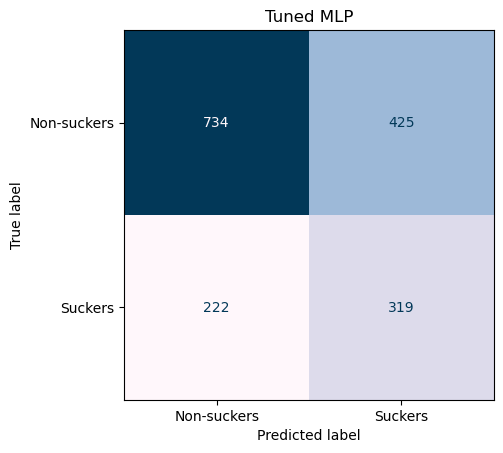

In [40]:
# RUS 
model9 = create_mlp(64, 'adam', X_train_scaled_encoded)
model9.fit(X_resampled_rus, y_resampled_rus, epochs=10, batch_size=32)

y_pred = model9.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("RUS 1 hidden, 64 nodes, adam", y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-suckers', 'Suckers'])
disp.plot(colorbar=False, cmap='PuBu')
plt.title('Tuned MLP')

In [41]:
# ROS 
model10 = create_mlp(64, 'adam', X_train_scaled_encoded)
model10.fit(X_resampled_ros, y_resampled_ros, epochs=10, batch_size=32)

y_pred = model10.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("ROS 1 hidden, 64 nodes, adam", y_test, y_pred)
cm

Epoch 1/10
169/169 [==============================] - 0s 885us/step - loss: 0.6613 - accuracy: 0.6106 - recall: 0.5759
Epoch 2/10
169/169 [==============================] - 0s 891us/step - loss: 0.6427 - accuracy: 0.6328 - recall: 0.6085
Epoch 3/10
169/169 [==============================] - 0s 902us/step - loss: 0.6360 - accuracy: 0.6450 - recall: 0.6392
Epoch 4/10
169/169 [==============================] - 0s 902us/step - loss: 0.6299 - accuracy: 0.6495 - recall: 0.6388
Epoch 5/10
169/169 [==============================] - 0s 891us/step - loss: 0.6213 - accuracy: 0.6607 - recall: 0.6497
Epoch 6/10
169/169 [==============================] - 0s 885us/step - loss: 0.6178 - accuracy: 0.6661 - recall: 0.6772
Epoch 7/10
169/169 [==============================] - 0s 885us/step - loss: 0.6140 - accuracy: 0.6613 - recall: 0.6622
Epoch 8/10
169/169 [==============================] - 0s 896us/step - loss: 0.6105 - accuracy: 0.6630 - recall: 0.6506
Epoch 9/10
169/169 [============================

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[831, 328],
       [284, 257]], dtype=int64)

In [42]:
# RUS 
model11 = create_mlp(64, 'adam', X_train_scaled_encoded)
model11.fit(X_resampled_rus, y_resampled_rus, epochs=10, batch_size=25)

y_pred = model11.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("RUS, adam, batch 25", y_test, y_pred)
cm

Epoch 1/10
101/101 [==============================] - 0s 858us/step - loss: 0.6822 - accuracy: 0.5681 - recall: 0.6165
Epoch 2/10
101/101 [==============================] - 0s 868us/step - loss: 0.6503 - accuracy: 0.6268 - recall: 0.6296
Epoch 3/10
101/101 [==============================] - 0s 898us/step - loss: 0.6431 - accuracy: 0.6284 - recall: 0.6488
Epoch 4/10
101/101 [==============================] - 0s 878us/step - loss: 0.6372 - accuracy: 0.6351 - recall: 0.6319
Epoch 5/10
101/101 [==============================] - 0s 888us/step - loss: 0.6338 - accuracy: 0.6446 - recall: 0.6368
Epoch 6/10
101/101 [==============================] - 0s 878us/step - loss: 0.6280 - accuracy: 0.6525 - recall: 0.6666
Epoch 7/10
101/101 [==============================] - 0s 868us/step - loss: 0.6252 - accuracy: 0.6498 - recall: 0.6498
Epoch 8/10
101/101 [==============================] - 0s 858us/step - loss: 0.6214 - accuracy: 0.6640 - recall: 0.6766
Epoch 9/10
101/101 [============================

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[736, 423],
       [238, 303]], dtype=int64)

In [43]:
y_train.shape

(3965, 1)

## <a id='3.6dropgroom'></a> 3.6 out of curiosity, does MLP still perform well with grooming dropped?
I only bring this up because a little birdy told me the kennels are short-staffed and recording # of hairball incidents adds to much time to the rounds. 

In [44]:
X_train_no_groom = X_train.drop(columns=['Grooming'])
X_test_no_groom = X_test.drop(columns=['Grooming'])

print(X_train_no_groom.shape)
print(X_test_no_groom.shape)

# one-hot breed 
X_train_encoded_no_groom = pd.get_dummies(X_train_no_groom, columns=['Breed_group'])
X_test_encoded_no_groom = pd.get_dummies(X_test_no_groom, columns=['Breed_group'])

print(X_train_encoded_no_groom.shape)
print(X_test_encoded_no_groom.shape)

scaler = StandardScaler()
scaler.fit(X_train_encoded)
X_train_scaled_encoded_ng = scaler.transform(X_train_encoded)
X_test_scaled_encoded_ng = scaler.transform(X_test_encoded)

print(X_train_scaled_encoded_ng.shape)
print(X_test_scaled_encoded_ng.shape)

rus = RandomUnderSampler()
X_resampled_rus_ng, y_resampled_rus_ng = rus.fit_resample(X_train_scaled_encoded, y_train)

(3965, 6)
(1700, 6)
(3965, 24)
(1700, 24)
(3965, 25)
(1700, 25)


In [45]:
print(X_train_scaled_encoded_ng.shape)
print(X_resampled_rus_ng.shape)
print(X_train_scaled_encoded.shape)

(3965, 25)
(2524, 25)
(3965, 25)


Epoch 1/10
79/79 [==============================] - 0s 844us/step - loss: 0.6720 - accuracy: 0.5947 - recall: 0.6089
Epoch 2/10
79/79 [==============================] - 0s 870us/step - loss: 0.6530 - accuracy: 0.6173 - recall: 0.6350
Epoch 3/10
79/79 [==============================] - 0s 882us/step - loss: 0.6471 - accuracy: 0.6288 - recall: 0.6417
Epoch 4/10
79/79 [==============================] - 0s 882us/step - loss: 0.6437 - accuracy: 0.6240 - recall: 0.6287
Epoch 5/10
79/79 [==============================] - 0s 895us/step - loss: 0.6409 - accuracy: 0.6406 - recall: 0.6423
Epoch 6/10
79/79 [==============================] - 0s 870us/step - loss: 0.6370 - accuracy: 0.6331 - recall: 0.6611
Epoch 7/10
79/79 [==============================] - 0s 870us/step - loss: 0.6339 - accuracy: 0.6426 - recall: 0.6334
Epoch 8/10
79/79 [==============================] - 0s 895us/step - loss: 0.6298 - accuracy: 0.6414 - recall: 0.6446
Epoch 9/10
79/79 [==============================] - 0s 895us/ste

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


Text(0.5, 1.0, 'MLP, No Grooming')

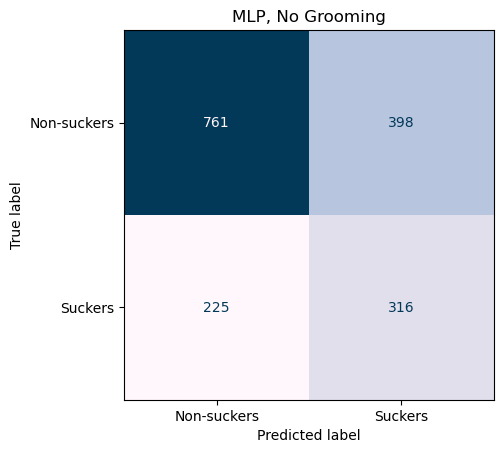

In [46]:
# RUS 64 adam scaled no grooming
model11 = create_mlp(64, 'adam', X_resampled_rus_ng)
model11.fit(X_resampled_rus_ng, y_resampled_rus_ng, epochs=10, batch_size=32)

y_pred = model11.predict(X_test_scaled_encoded_ng)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("no groom, RUS, 64, adam", y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-suckers', 'Suckers'])
disp.plot(colorbar=False, cmap='PuBu')
plt.title('MLP, No Grooming')

In [47]:
master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,"RUS 1 hidden, 64 nodes, adam",0.590,0.496,0.429,0.619
11,"no groom, RUS, 64, adam",0.584,0.504,0.443,0.634
10,"RUS, adam, batch 25",0.560,0.478,0.417,0.611
9,"ROS 1 hidden, 64 nodes, adam",0.475,0.456,0.439,0.640
2,"1 hidden, 64 nodes per, adam, scaled",0.283,0.359,0.492,0.679


# <a id='4evaluation'></a> 4. Model evaluation 

## <a id='4.1'></a> 4.1 Training and Prediction Time 

In [48]:
import time
# training time 
start = time.time()
model10.fit(X_resampled_ros, y_resampled_ros, epochs=10, batch_size=32)
end = time.time()
training_time = end - start

p_start = time.time()
y_pred = model10.predict(X_test_encoded)
p_end = time.time()
predict_time = p_end - p_start

Epoch 1/10
169/169 [==============================] - 0s 896us/step - loss: 0.5969 - accuracy: 0.6724 - recall: 0.6720
Epoch 2/10
169/169 [==============================] - 0s 891us/step - loss: 0.5929 - accuracy: 0.6787 - recall: 0.6871
Epoch 3/10
169/169 [==============================] - 0s 896us/step - loss: 0.5913 - accuracy: 0.6883 - recall: 0.7062
Epoch 4/10
169/169 [==============================] - 0s 902us/step - loss: 0.5880 - accuracy: 0.6848 - recall: 0.6884
Epoch 5/10
169/169 [==============================] - 0s 896us/step - loss: 0.5805 - accuracy: 0.6876 - recall: 0.6954
Epoch 6/10
169/169 [==============================] - 0s 902us/step - loss: 0.5800 - accuracy: 0.6935 - recall: 0.7110
Epoch 7/10
169/169 [==============================] - 0s 896us/step - loss: 0.5772 - accuracy: 0.6937 - recall: 0.7105
Epoch 8/10
169/169 [==============================] - 0s 896us/step - loss: 0.5748 - accuracy: 0.6968 - recall: 0.6940
Epoch 9/10
169/169 [============================

## <a id='4.2'></a> 4.2 Comparing to a Logistic Regression
In Cat-pstone 1 I had did not prune down the columns nearly as much. I want to see how it does with this new training set. 

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


Text(0.5, 1.0, "Logistic Regression, class_weight='balanced'")

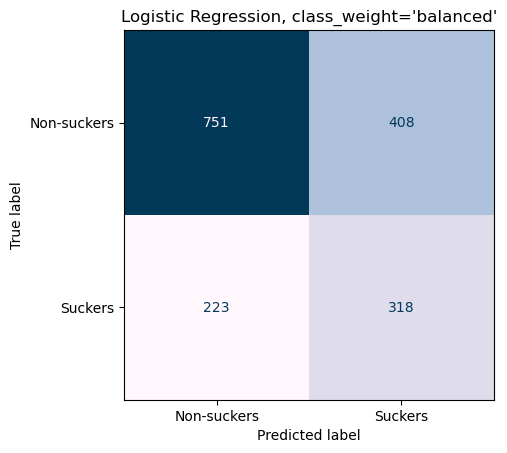

In [49]:
from sklearn.linear_model import LogisticRegression

# fit model, + training time 
t_start = time.time()
log_balanced = LogisticRegression(class_weight='balanced').fit(X_train_encoded, (y_train.values.reshape(-1)))
t_end = time.time()
log_training = t_end - t_start

# predict w model, + prediction time 
p_start = time.time()
y_pred = log_balanced.predict(X_test_encoded)
p_end = time.time()
log_predict = p_end - p_start 

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("class_weight='balanced', LogReg", y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-suckers', 'Suckers'])
disp.plot(colorbar=False, cmap='PuBu')
plt.title("Logistic Regression, class_weight='balanced'")

In [50]:
# scaled and logistic regression
log_balanced_scaled = LogisticRegression(class_weight='balanced').fit(X_train_scaled_encoded, (y_train.values.reshape(-1)))
y_pred = log_balanced_scaled.predict(X_test_scaled_encoded)

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("class_weight='balanced', LogReg, scaled", y_test, y_pred);

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


In [51]:
print(f"MLP training time: {training_time} \nMLP predict time: {predict_time} \nLogistic Regression training time: {log_training} \nLogistic Regression predict time: {log_predict}")
train_ratio = round(training_time / log_training, 1)
predict_ratio = round(predict_time / log_predict, 1)
print(f"MLP is {train_ratio} times slower at training than logistic regression. \nMLP is {predict_ratio} times slower at predicting than logistic regression." )
# AND I didn't even include the time spent doing a random undersampling for the MLP, which logistic reg didn't need 

MLP training time: 1.5938448905944824 
MLP predict time: 0.13165664672851562 
Logistic Regression training time: 0.019948244094848633 
Logistic Regression predict time: 0.0019948482513427734
MLP is 79.9 times slower at training than logistic regression. 
MLP is 66.0 times slower at predicting than logistic regression.


### <a id='4.2.1'></a> 4.2.1 Logistic Regression No Grooming

C:\Users\gwent\anaconda3\envs\wool_sucking_nn\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


Text(0.5, 1.0, 'Logistic Regression, No Grooming')

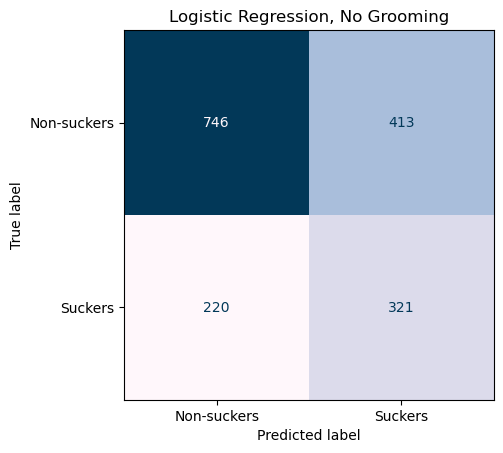

In [52]:
# no grooming logistic regression 
log_no_groom = LogisticRegression(class_weight='balanced').fit(X_train_scaled_encoded_ng, y_train)
y_pred = log_no_groom.predict(X_test_scaled_encoded_ng)

add_to_master('log reg no grooming', y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-suckers', 'Suckers'])
disp.plot(colorbar=False, cmap='PuBu')
plt.title("Logistic Regression, No Grooming")

In [53]:
# for reference, cat-pstone 1 model was 0.622, 0.519, 0.446, 0.635
master_scores.sort_values('Recall', ascending=False).head(10)

,Model,Recall,F1,Precision,Accuracy
13,"class_weight='balanced', LogReg, scaled",0.593,0.504,0.437,0.628
14,log reg no grooming,0.593,0.504,0.437,0.628
8,"RUS 1 hidden, 64 nodes, adam",0.590,0.496,0.429,0.619
12,"class_weight='balanced', LogReg",0.588,0.502,0.438,0.629
11,"no groom, RUS, 64, adam",0.584,0.504,0.443,0.634
10,"RUS, adam, batch 25",0.560,0.478,0.417,0.611
9,"ROS 1 hidden, 64 nodes, adam",0.475,0.456,0.439,0.640
2,"1 hidden, 64 nodes per, adam, scaled",0.283,0.359,0.492,0.679
4,"1 hidden, 100 nodes, adam",0.279,0.347,0.459,0.666
7,"1 hidden, 300 nodes, adam",0.275,0.350,0.481,0.675


## <a id='4.3'></a>4.3 Old data MLP 

In [54]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('..\Data\cat_clean.csv')

In [55]:
# binarize wool-sucking
df_bin = df.copy()
df_bin['ws_binary'] = df_bin['Wool_sucking'].replace([1, 2, 3, 4, 5, 6, 7], [1, 1, 1, 1, 1, 1, 1])
df_bin.drop(columns='Wool_sucking', inplace=True)

# Recode Behaviour_problem to binary
df_bin['Behaviour_problem'].replace([1, 2, 3], [0, 1, 1], inplace=True)

# encode breed group
df_bin_encoded = pd.get_dummies(df_bin, columns=['Breed_group'])

In [56]:
X = df_bin_encoded.drop(columns=['ws_binary'])
y = df_bin_encoded['ws_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# making agg columns for training set 
X_train['agg_shy'] = (X_train['Shyness_novel'] + X_train['Shyness_strangers']) / 2
X_train['agg_aggress_people'] = (X_train['Aggression_owner'] + X_train['Aggression_stranger']) / 2 
X_train.drop(columns=['Shyness_novel', 'Shyness_strangers', 'Aggression_stranger', 'Aggression_owner'], inplace=True)
X_train.columns

# making agg columns for testing set
X_test['agg_shy'] = (X_test['Shyness_novel'] + X_test['Shyness_strangers']) / 2
X_test['agg_aggress_people'] = (X_test['Aggression_owner'] + X_test['Aggression_stranger']) / 2
X_test.drop(columns=['Shyness_novel', 'Shyness_strangers', 'Aggression_stranger', 'Aggression_owner'], inplace=True)
X_test.columns

Index(['Age', 'Gender', 'Neuter_status', 'Weaning_age', 'Outdoors',
       'Other_cats', 'Activity_level', 'Contact_people', 'Aggression_cats',
       'Grooming', 'Behaviour_problem', 'Breed_group_ABY', 'Breed_group_BEN',
       'Breed_group_BRI', 'Breed_group_BUR', 'Breed_group_CRX',
       'Breed_group_DRX', 'Breed_group_EUR', 'Breed_group_HCS',
       'Breed_group_KOR', 'Breed_group_MCO', 'Breed_group_NFO',
       'Breed_group_ORI', 'Breed_group_PER', 'Breed_group_RAG',
       'Breed_group_RUS', 'Breed_group_SBI', 'Breed_group_SIB',
       'Breed_group_TUV', 'Breed_group_other', 'agg_shy',
       'agg_aggress_people'],
      dtype='object')

In [57]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled_encoded = scaler.transform(X_train)
X_test_scaled_encoded = scaler.transform(X_test)

rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train_scaled_encoded, y_train)

model12 = create_mlp(64, 'adam', X_resampled_rus)
model12.fit(X_resampled_rus, y_resampled_rus, epochs=10, batch_size=32)

y_pred = model12.predict(X_test_scaled_encoded)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
add_to_master("old data rus adam 64", y_test, y_pred)
cm

Epoch 1/10
79/79 [==============================] - 0s 857us/step - loss: 0.6725 - accuracy: 0.5823 - recall: 0.6261
Epoch 2/10
79/79 [==============================] - 0s 882us/step - loss: 0.6342 - accuracy: 0.6441 - recall: 0.6807
Epoch 3/10
79/79 [==============================] - 0s 882us/step - loss: 0.6201 - accuracy: 0.6576 - recall: 0.6550
Epoch 4/10
79/79 [==============================] - 0s 895us/step - loss: 0.6104 - accuracy: 0.6675 - recall: 0.6804
Epoch 5/10
79/79 [==============================] - 0s 882us/step - loss: 0.6011 - accuracy: 0.6778 - recall: 0.6882
Epoch 6/10
79/79 [==============================] - 0s 882us/step - loss: 0.5932 - accuracy: 0.6746 - recall: 0.6785
Epoch 7/10
79/79 [==============================] - 0s 882us/step - loss: 0.5860 - accuracy: 0.6940 - recall: 0.7042
Epoch 8/10
79/79 [==============================] - 0s 985us/step - loss: 0.5759 - accuracy: 0.6952 - recall: 0.6963
Epoch 9/10
79/79 [==============================] - 0s 908us/ste

C:\Users\gwent\AppData\Local\Temp\ipykernel_3948\1005917253.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


array([[650, 517],
       [169, 373]], dtype=int64)

In [58]:
# for reference, cat-pstone 1 model was 0.622, 0.519, 0.446, 0.635
# it really doesn't do any better than a weighted LR model, in either dataset
master_scores.sort_values(['Recall', 'Accuracy'], ascending=False)

,Model,Recall,F1,Precision,Accuracy
15,old data rus adam 64,0.688,0.521,0.419,0.599
13,"class_weight='balanced', LogReg, scaled",0.593,0.504,0.437,0.628
14,log reg no grooming,0.593,0.504,0.437,0.628
8,"RUS 1 hidden, 64 nodes, adam",0.590,0.496,0.429,0.619
12,"class_weight='balanced', LogReg",0.588,0.502,0.438,0.629
11,"no groom, RUS, 64, adam",0.584,0.504,0.443,0.634
10,"RUS, adam, batch 25",0.560,0.478,0.417,0.611
9,"ROS 1 hidden, 64 nodes, adam",0.475,0.456,0.439,0.640
2,"1 hidden, 64 nodes per, adam, scaled",0.283,0.359,0.492,0.679
4,"1 hidden, 100 nodes, adam",0.279,0.347,0.459,0.666
